# Simulating searching constellation of known object from stars

This notebook is to simulate searching for a constellation in a way that the person knows what it is looking for. E.g. I'm looking for sunglasses from given set of stars

## Import dependecies

In [1]:
import os
import matplotlib.pyplot as plt
import clip
import torch
from torchvision.datasets import CIFAR100
#from torchvision.datasets import CocoDetection
import numpy as np
from numpy import linalg as LA
import PIL
%matplotlib inline

#Had OpenMPI issue
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%load_ext autoreload
%autoreload 2

## Load constellations

In [2]:
# Load constellations
from dataUtils import * 
pictures = loadConstellations(pictureTypes=["original", "final_easy", "outline"])

## Select one set of stars

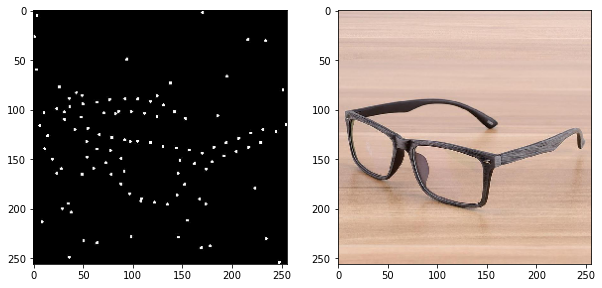

In [3]:
### Visualize selected image and its original
imageIdx = 39 #Windows 6
objectId = list(pictures.keys())[imageIdx]
constellationImage = pictures[objectId]["final_easy"][-1]
outlineImage = pictures[objectId]["outline"][0]
originalImage = pictures[objectId]["original"][0]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
ax1.imshow(constellationImage)
ax2.imshow(originalImage)

## Load the classes for zero-shot learning

In [4]:
#Available classifications from different datasets
#combinedClasses.txt - CoCo + CIFAR100 (around 160 classes, removed duplicates)
#combinedClassesAdditional.txt -CoCo + CIFAR100 + classes about pictures which constellations are in set but 
#not in either CoCo or CIFAR100 classes (around 180 classes, removed duplicates)
#combinedClassesAdditional.txt - small set of classes for quicker testing
#cocoClasses.txt - CoCo (80 classes)
#cifarClasses.txt - Cifar100 (100 classes)
#imagenet_classes.txt - Imagenet classes (around 1000 classes)

chosenDataset = "combinedClassesAdditional_Small.txt"
# Read the categories
with open(os.path.join("classes",chosenDataset), "r") as f:
    categories = [s.strip() for s in f.readlines()]

## Check that the classes contain class related to the chosen set of stars

In [5]:
"sunglasses" in categories #Sunglasses close enough for glasses

True

In [6]:
classIndex = categories.index("sunglasses") #Memorize class index

## Find coordinates of stars

In [7]:
from starUtils import *
coords = findStarCoordinates(constellationImage)

In [8]:
from scipy.spatial import distance_matrix
distances = distance_matrix(coords, coords)
averageDistanceBetweenPoints = np.mean(distances)
averageDistanceBetweenPoints

109.51508305760512

## Load pretrained CLIP model

In [9]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
#Different architectures, choose one
model, preprocess = clip.load('ViT-B/32', device) #Faster
#model, preprocess = clip.load('RN50x4', device) #Better but takes more time

## Set classes up for CLIP

In [10]:
classesInput = torch.cat([clip.tokenize(f"a photo of a {c}") for c in categories]).to(device)

## Check that at first the model is not convinced of the class

In [11]:
def estimatePictureWithCLIP(constellationImg, text_inputs):
    image = PIL.Image.fromarray(constellationImg)
    image_input = preprocess(image).unsqueeze(0).to(device)
    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
    
    #Estimate the similarities between pictures and given classes
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    return similarity

In [12]:
def showTopPredictions(similarities, categories, numberOfResults=5):
    values, indices = similarities[0].topk(numberOfResults)
    # Print the result
    print("\nTop predictions:\n")
    for value, index in zip(values, indices):
        print(f"{categories[index]:>16s}: {100 * value.item():.2f}%")

In [13]:
def getTrueClassPrediction(similarities, categoryIndex):
    values = similarities[0]
    return float(values[categoryIndex])

In [14]:
predictions = estimatePictureWithCLIP(constellationImage, classesInput)
showTopPredictions(predictions, categories)


Top predictions:

        dinosaur: 18.12%
          cattle: 15.71%
       crocodile: 7.91%
            bear: 6.40%
         dolphin: 5.85%


In [15]:
print(f"{categories[classIndex]} has probability of {100 * getTrueClassPrediction(predictions, classIndex):.2f}%")

sunglasses has probability of 1.52%


## Make directory where to save the mean steps

In [16]:
simNr = 0
dirname = "sim_"
while(True):
    try:
        saveDir = os.path.join(".", "simulations", "simulateSearchingKnownObjectFromStars", (dirname+str(simNr)))
        os.mkdir(saveDir)
        break
    except FileExistsError:
        simNr+=1      

## Start looking for constellations by connecting stars

Two different strategies possible:
* Select first point at random an only consider points that are already connected for drawing next line
* In case of each decision it is possible to connect every point with all other points

In [17]:
threshold = 0.95 #How convinced the evaluator should be of the true class to stop
stepNr = 0
chosenPoints = []
drawnLines = []
visitedPoints = dict()
for coord in coords:
    visitedPoints[coord] = 0
bestPicture = constellationImage
bestPrediction = getTrueClassPrediction(predictions, classIndex)
#Store the first image
PIL.Image.fromarray(bestPicture).save(os.path.join(saveDir, str(stepNr)+".png"))

In [18]:
#Selected one point in constellation instead of random
startingPoint = (254, 115) #[coords[np.random.randint(0,len(coords))]] 
chosenPoints += [startingPoint]
visitedPoints[startingPoint] += 1

In [19]:
#chosenPoints = [(144, 186), (249, 138)]
#stepNr=1
#PIL.Image.fromarray(previousStepBestPicture)
#bestPicture = previousStepBestPicture

## #Testing taking first point random drawing lines from already connected points

In [20]:
while(bestPrediction<threshold):
    
    ### Update parameters
    stepNr+=1
    lineFound = False
    previousStepBestPicture = bestPicture
    previousStepBestPrediction = bestPrediction
    bestPrediction = 0
    bestPredictionScaled = 0
    
    #Print out step info
    print(stepNr)
    print(chosenPoints)
    
    #Take starting point from one of already connected points
    for chosenPoint in chosenPoints:
        for endPoint in coords:
            #Do not chose dot as line and point we have been in this point less than 2 times
            if(chosenPoint==endPoint or visitedPoints[endPoint]>3):
                continue
            #Do not draw the same line twice
            toSkip = False
            for drawnLine in drawnLines:
                if((chosenPoint==drawnLine[0] and endPoint==drawnLine[1]) or (chosenPoint==drawnLine[1] and endPoint==drawnLine[0])):
                    toSkip = True
                    break
            if(toSkip):
                continue
            #Skip point which are too far 
            distanceBetweenPoints = LA.norm(np.asarray(chosenPoint)-np.asarray(endPoint))
            if(averageDistanceBetweenPoints*0.5>distanceBetweenPoints):
                newPicture = drawLine(previousStepBestPicture, chosenPoint, endPoint)
                predictions = estimatePictureWithCLIP(newPicture, classesInput)
                currentPrediction = getTrueClassPrediction(predictions, classIndex)
                currentPredictionScaled = currentPrediction/(distanceBetweenPoints)**0.5
               #Scale to penalize long lines - long line should bring more benefit than short line
                #Enforce that the prediction improves overall result
                if(bestPredictionScaled<currentPredictionScaled and currentPrediction>(previousStepBestPrediction-0.01)):
                    bestPicture = newPicture
                    bestPrediction = currentPrediction
                    bestPredictionScaled = currentPredictionScaled
                    bestEndPoint = endPoint
                    bestStartPoint = chosenPoint
                    lineFound = True
    
    #If couldnt find suitable points break
    if(not lineFound):
        print("Couldn't find better connection, stopping!")
        break
    
    #Add best end point to list of connected points
    chosenPoints+=[bestEndPoint]
    drawnLines+=[(bestStartPoint,bestEndPoint)]
    visitedPoints[bestEndPoint]+=1
    if stepNr>1:
        #Remove the best starting point
        chosenPoints.remove(bestStartPoint)
    #Store the picture
    PIL.Image.fromarray(bestPicture).save(os.path.join(saveDir, str(stepNr)+".png"))
    print(f"Line from {bestStartPoint}->{bestEndPoint}")
    print(f"{categories[classIndex]} has probability of {100 * bestPrediction:.2f}%")

1
[(254, 115)]
Line from (254, 115)->(251, 80)
sunglasses has probability of 1.26%
2
[(254, 115), (251, 80)]
Line from (254, 115)->(244, 122)
sunglasses has probability of 0.86%
3
[(251, 80), (244, 122)]
Line from (244, 122)->(231, 120)
sunglasses has probability of 0.66%
4
[(251, 80), (231, 120)]
Line from (231, 120)->(254, 115)
sunglasses has probability of 1.31%
5
[(251, 80), (254, 115)]
Line from (254, 115)->(219, 123)
sunglasses has probability of 1.37%
6
[(251, 80), (219, 123)]
Line from (219, 123)->(231, 120)
sunglasses has probability of 1.40%
7
[(251, 80), (231, 120)]
Line from (231, 120)->(216, 137)
sunglasses has probability of 1.72%
8
[(251, 80), (216, 137)]
Line from (216, 137)->(229, 133)
sunglasses has probability of 2.02%
9
[(251, 80), (229, 133)]
Line from (229, 133)->(219, 123)
sunglasses has probability of 1.84%
10
[(251, 80), (219, 123)]
Line from (219, 123)->(206, 128)
sunglasses has probability of 2.01%
11
[(251, 80), (206, 128)]
Line from (206, 128)->(192, 146)
s

Line from (36, 97)->(31, 102)
sunglasses has probability of 1.83%
89
[(216, 29), (31, 102)]
Line from (31, 102)->(31, 109)
sunglasses has probability of 1.71%
90
[(216, 29), (31, 109)]
Line from (31, 109)->(23, 99)
sunglasses has probability of 1.71%
91
[(216, 29), (23, 99)]
Line from (23, 99)->(31, 102)
sunglasses has probability of 1.68%
92
[(216, 29), (31, 102)]
Line from (31, 102)->(48, 107)
sunglasses has probability of 1.76%
93
[(216, 29), (48, 107)]
Line from (48, 107)->(54, 118)
sunglasses has probability of 1.92%
94
[(216, 29), (54, 118)]
Line from (54, 118)->(53, 132)
sunglasses has probability of 1.98%
95
[(216, 29), (53, 132)]
Line from (53, 132)->(64, 139)
sunglasses has probability of 1.77%
96
[(216, 29), (64, 139)]
Line from (64, 139)->(73, 153)
sunglasses has probability of 1.96%
97
[(216, 29), (73, 153)]
Line from (73, 153)->(77, 141)
sunglasses has probability of 2.05%
98
[(216, 29), (77, 141)]
Line from (77, 141)->(88, 149)
sunglasses has probability of 2.10%
99
[(21